In [62]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
#loading VGG16 without the classification layers and disableling the convolutional layers
model = VGG16()

In [101]:
def lables(type):
    df = pd.read_json(f"../../images/metadata/{type}_data.json", lines=True)
    lables = df['class_label']
    uniqie_classes = lables.unique()
    
    return lables, unique_classes

In [102]:
train_lables = lables("train")[0]
test_lables = lables("test")[0]

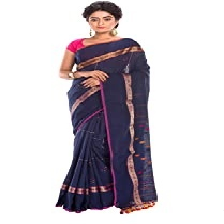

In [144]:
#load data (test with one image)
test = load_img('../../images/test/0.jpeg', target_size=(224, 224))
train = load_img('../../images/train/0.jpeg', target_size=(224, 224))
test

In [149]:
def prepare_image(type): #type of data you want to load i.e. test, train or val
    for img in os.listdir(f"../../images/{type}/"):
        image = load_img(f"../../images/{type}/{img}", target_size=(224, 224))
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        prepared_image = preprocess_input(image)
        prepared_image = prepared_image.astype("float") / 255.

    return prepared_image

test_prepared = prepare_image('test')

KeyboardInterrupt: 

In [ ]:
def prepare_image(path):
    df = os.path.join(path)
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    prepared_image = preprocess_input(image)

    return prepared_image

In [147]:
train_data = train_prepared.astype("float") / 255.
test_data = test_prepared.astype("float") / 255.
train_data

array([[[[0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         ...,
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042]],

        [[0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         ...,
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042]],

        [[0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         ...,
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042]],

        ...,

        [[0.5923961 , 0.54204317, 0.51498042],
         [0.5923961 , 0.54204317, 0.51498042]

In [122]:
# integers to one-hot vectors
lb = LabelBinarizer()
train_lables = lb.fit_transform(train_lables)
test_lables = lb.fit_transform(test_lables)

labelNames = lables("train")[1]
labelNames = labelNames.tolist()
labelNames

['saree',
 'blouse',
 'dhoti_pants',
 'dupattas',
 'gowns',
 'kurta_men',
 'leggings_and_salwars',
 'lehenga',
 'mojaris_men',
 'mojaris_women',
 'nehru_jackets',
 'palazzos',
 'petticoats',
 'sherwanis',
 'women_kurta']

In [125]:
train_data.shape

(1, 224, 224, 3)

In [131]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [132]:
tf.keras.backend.clear_session()
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [133]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [134]:
H = model.fit(train_data, train_lables, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.1`. Either provide more data, or a different value for the `validation_split` argument.